In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sys import maxsize


In [9]:
def rangelimits(channel):
        min_ = np.min(channel)
        max_ = np.max(channel)
        return min_, max_

def find_range(img, binary_mask):
    # Split image into B, G, R
    blue, green, red = cv2.split(img)
    # Convert mask image into HSV space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Get values of each channel
    hue, saturation, value = cv2.split(hsv_img)
    # Apply Mask
    red &= binary_mask
    green &= binary_mask
    blue &= binary_mask

    hue &= binary_mask
    saturation &= binary_mask
    value &= binary_mask

    r_range = rangelimits(red[red > 0].flatten())
    g_range = rangelimits(green[green > 0].flatten())
    b_range = rangelimits(blue[blue > 0].flatten())

    h_range = rangelimits(hue[hue > 0].flatten())
    s_range = rangelimits(saturation[saturation > 0].flatten())
    v_range = rangelimits(value[value > 0].flatten())

    bgr_lower = np.array([b_range[0], g_range[0], r_range[0]])
    bgr_upper = np.array([b_range[1], g_range[1], r_range[1]])

    hsv_lower = np.array([h_range[0], s_range[0], v_range[0]])
    hsv_upper = np.array([h_range[1], s_range[1], v_range[1]])

    return bgr_lower, bgr_upper, hsv_lower, hsv_upper

In [10]:
def pred_skin_color_mask(img, binary_mask):
    bgr_lower, bgr_upper, hsv_lower, hsv_upper = find_range(img, binary_mask)
    mask_BGR = cv2.inRange(img, bgr_lower, bgr_upper)
    mask_HSV = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, :-1], hsv_lower[:-1], hsv_upper[:-1])

    mask_combined = cv2.bitwise_and(mask_BGR, mask_HSV)

    return mask_combined


def pred_all_masks(imgs, binary_masks):
    predicted_masks = []
    for i, img in enumerate(imgs):
        pred_mask_combined = pred_skin_color_mask(img, binary_masks[i])
        predicted_masks.append( pred_mask_combined)

    return predicted_masks

In [11]:
    n_imgs = 10
    imgs = []
    masks = []

    pwd=os.getcwd()
    # Masks and Images base paths
    masks_base = pwd+"/data/Images/Ground Truths/"
    imgs_base = pwd+"/data/Images/Original Images/"

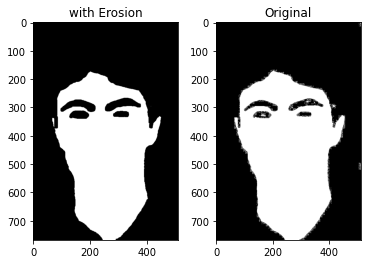

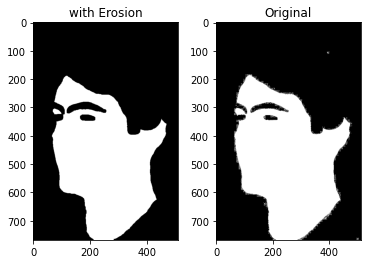

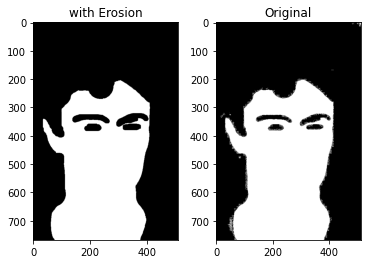

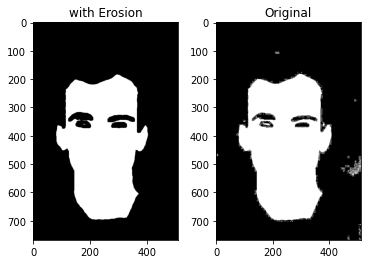

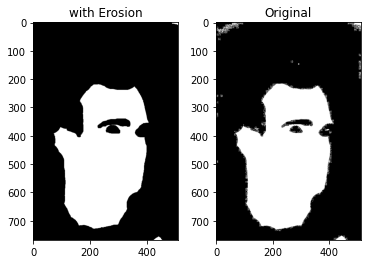

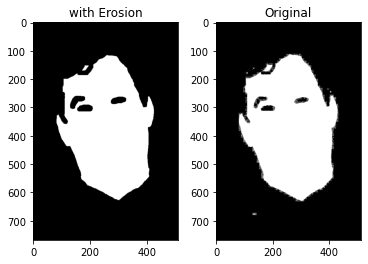

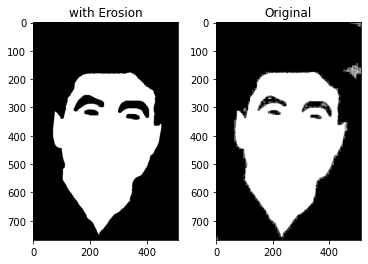

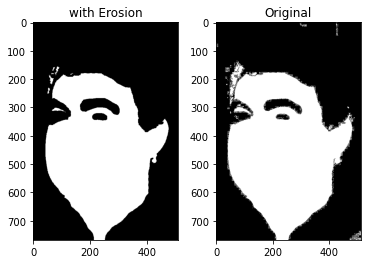

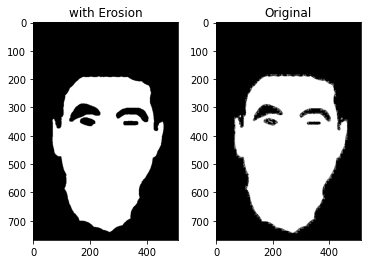

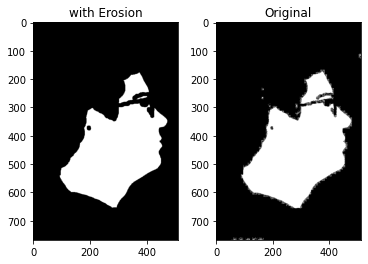

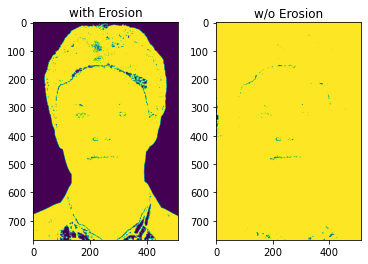

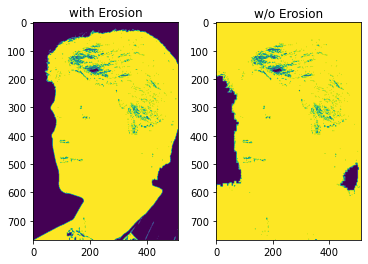

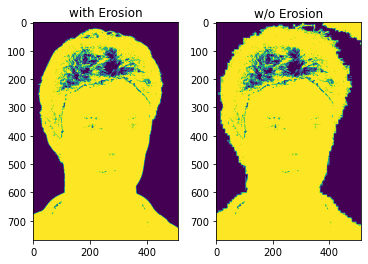

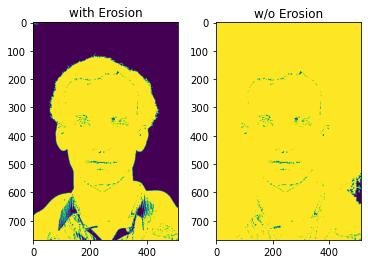

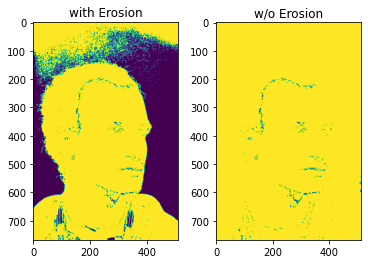

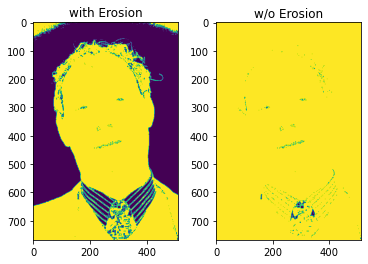

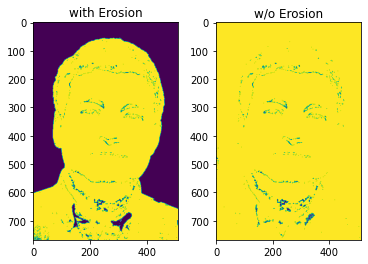

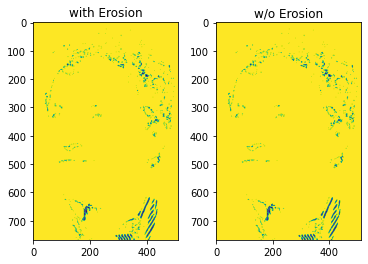

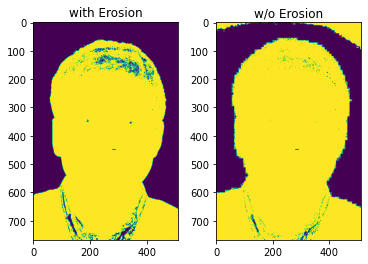

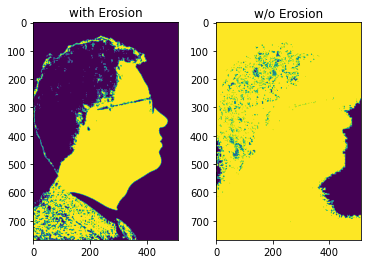

In [12]:
    # Read and store images and  masks
    for i in range(1, n_imgs + 1):
        img = cv2.imread(imgs_base + "img_" + "{0:03d}".format(i) + ".jpg", 1)
        mask = cv2.imread(masks_base + "mask_" + "{0:03d}".format(i) + ".jpg", 0)

        imgs.append(img)
        masks.append(mask)

    binary_masks = []
    for i, mask in enumerate(masks):
        _, temp_ = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
        plt.imshow(temp_, cmap='gray')
        plt.savefig("T2-Plots/bin_mask_{0:03d}".format(i + 1))
        binary_masks.append(temp_)

    predictions = pred_all_masks(imgs, binary_masks)
    for i, pred in enumerate(predictions):
        plt.imshow(pred)
        plt.savefig("T2-Plots/skin_color_mask_{0:03d}".format(i + 1))

    # Erosion
    masks_erosion = []
    kernel = np.ones((5, 5), np.uint8)
    for i, mask in enumerate(binary_masks):
        new_mask = cv2.erode(mask, kernel, iterations=1)
        masks_erosion.append(new_mask)
        plt.subplot("121")
        plt.imshow(new_mask, cmap='gray')
        plt.title("with Erosion")
        plt.subplot("122")
        plt.imshow(mask, cmap='gray')
        plt.title("Original")
        plt.savefig("T2-Plots/bin_mask_erode_{0:03d}".format(i + 1))
        plt.show()

    erosions = pred_all_masks(imgs, masks_erosion)
    for i, pred in enumerate(erosions):
        plt.subplot("121")
        plt.imshow(pred)
        plt.title("with Erosion")
        plt.subplot("122")
        plt.imshow(predictions[i])
        plt.title("w/o Erosion")
        plt.savefig("T2-Plots/skin_color_mask_erode_{0:03d}".format(i + 1))
        plt.show()

Using min-max range values to detect skin colors are not working well.To improve results of skin color segmentation, we should improve improve  segmentation  part. 
Using binary masks, we can constructs data set such that each skin pixel correspondsto 1, and non-skin pixel corresponds to 0 label.After that , we should split data set in 2 parts train and label. Then, we can train a binary classifier and test it.Applying logistic regression classifier classifier to image colors will give us better results.


In [13]:
def apply_skin_color_mask(img, binary_mask):

    skin_colors = img[binary_mask == 255, :]
    non_skin_colors = img[binary_mask == 0, :]

    #Takes a sequence of arrays and stack them vertically to make a single array.
    color = np.vstack((skin_colors, non_skin_colors))
    target = np.concatenate((np.ones(len(skin_colors)), np.zeros(len(non_skin_colors))))

    train , test, train_target, test_target = train_test_split(color, target, test_size=0.33)

    logistic = LogisticRegressionCV()
    logistic.fit(train, train_target)

    score = logistic.score(test, test_target)
    print("Test Results {}".format(score))

    #obtain 3 channel
    color_vectors = img.reshape(-1, 3)
    predict_skin = logistic.predict(color_vectors).reshape(img.shape[:-1])

    return predict_skin

In [14]:
binary_masks = np.load("masks.npy")
skin_color_masks = []
n_imgs = 20
imgs = [cv2.imread(imgs_base + "img_{0:03d}.jpg".format(i)) for i in range(1, n_imgs + 1)]

Test Results 0.9650668146298608
Test Results 0.9683420415838226
Test Results 0.953098750019266
Test Results 0.975786439789769
Test Results 0.9580539757402013
Test Results 0.9778979978730291
Test Results 0.9667005748986606
Test Results 0.9698370863581017
Test Results 0.9582389297328956
Test Results 0.9853346896626131
Test Results 0.9751699264807879
Test Results 0.9739291934464636
Test Results 0.963756723848276
Test Results 0.9796858864690742
Test Results 0.9609207626269632
Test Results 0.9603967263143293
Test Results 0.9780444197839121
Test Results 0.9618070005086234
Test Results 0.8747399084477736
Test Results 0.9487600376073119


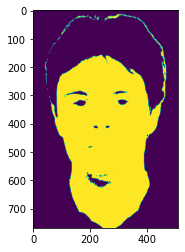

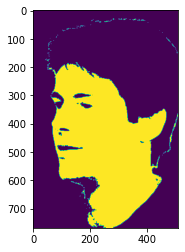

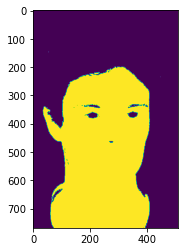

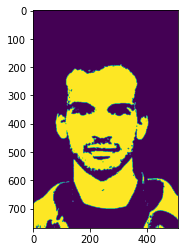

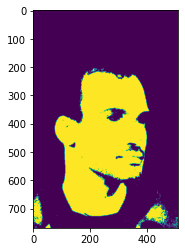

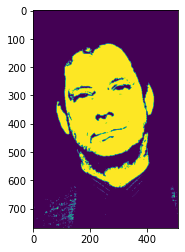

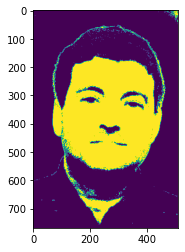

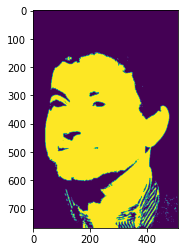

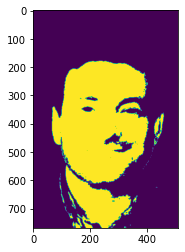

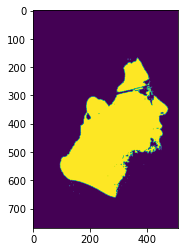

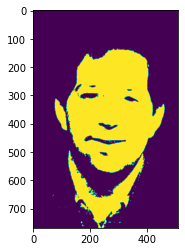

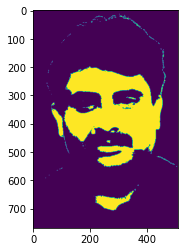

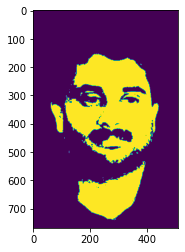

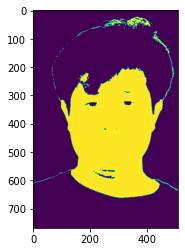

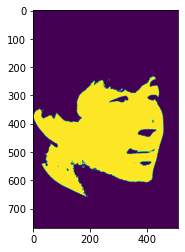

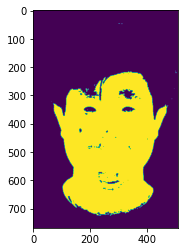

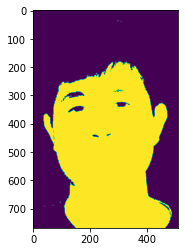

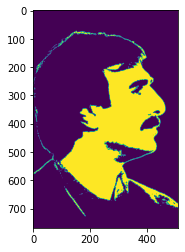

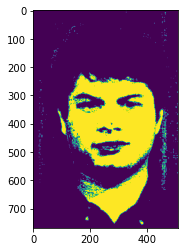

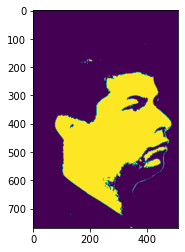

In [15]:
for i, binary_mask in enumerate(binary_masks):
    skin_color_mask = apply_skin_color_mask(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB), binary_mask)
    skin_color_masks.append(skin_color_mask)

for i, color_mask in enumerate(skin_color_masks):
    plt.imshow(color_mask)
    plt.savefig("Log-RegressionResults/skin_color_mask_{0:03d}".format(i+1))
    plt.show()